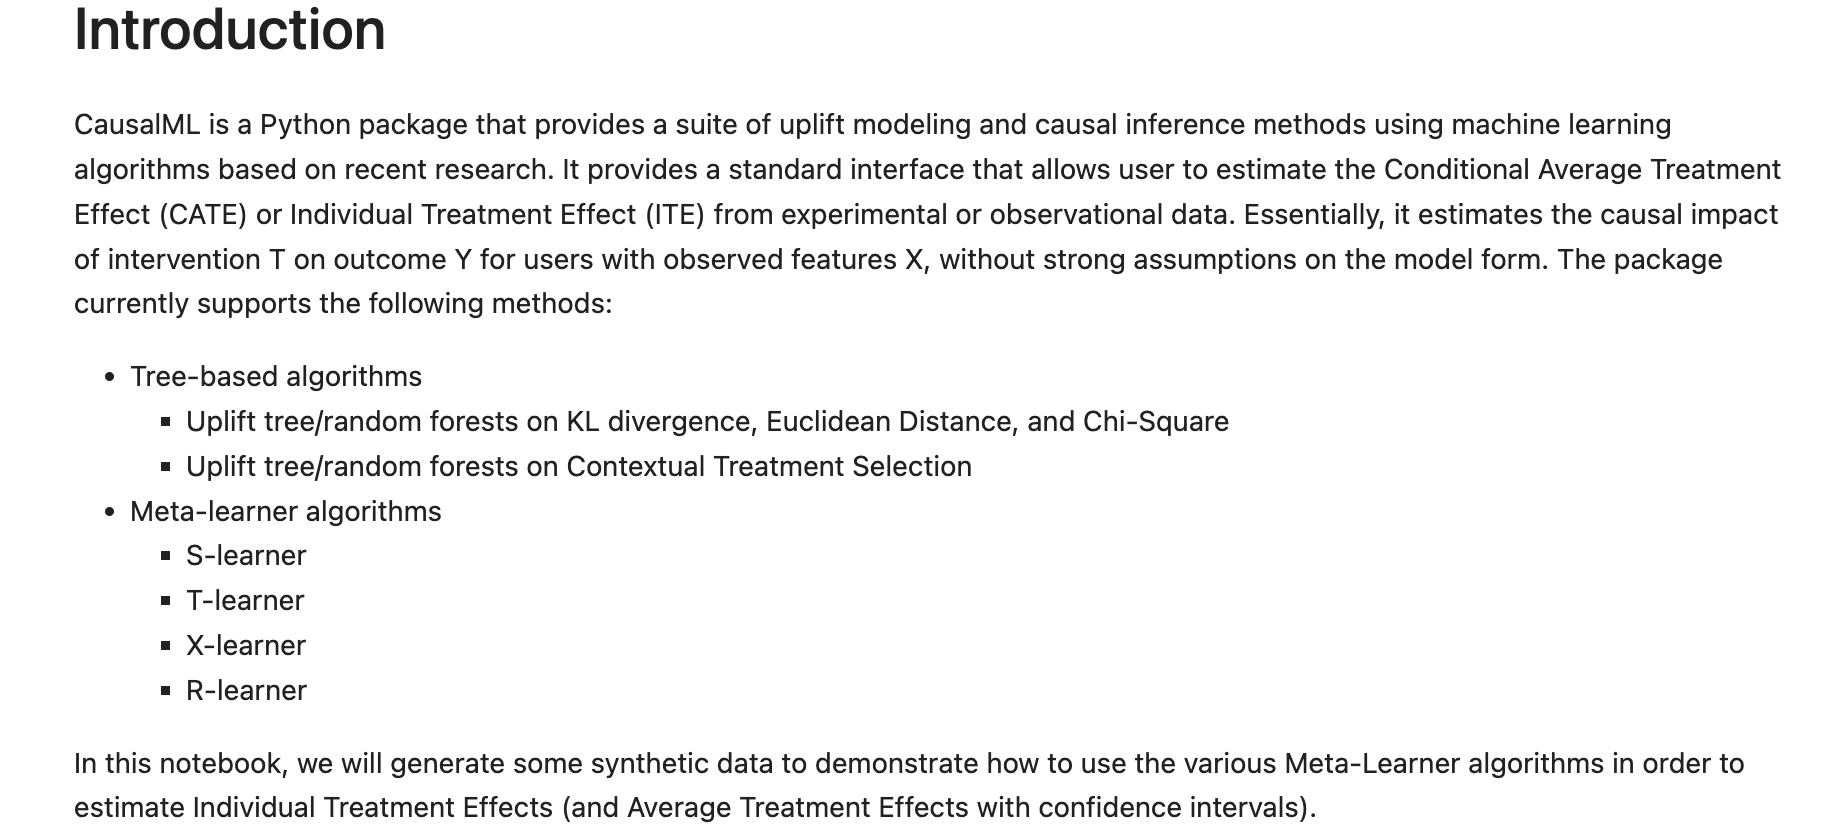

参考文献：https://cloud.tencent.com/developer/article/1913941

In [1]:
from causalml.inference.meta import LRSRegressor

/opt/anaconda3/envs/causalml-tf-py37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

In [3]:
import causalml
print(causalml.__version__)

0.12.3


In [9]:
#使用synthetic_data生成数据，针对回归任务的数据生成
y, X, treatment, _, _, e = synthetic_data(mode=1, n=1000, p=5, sigma=1.0)
y, X, treatment,e

(array([ 1.83313493e+00,  1.41775516e+00,  2.03216718e+00,  3.49692232e+00,
         2.31438709e+00,  2.33830463e+00,  1.39059190e+00,  8.60889330e-01,
         3.12235276e+00,  1.14547417e+00,  1.37366182e+00,  2.40367333e+00,
         2.15875832e+00,  2.00021078e+00,  9.49653807e-01,  2.32020032e-01,
         3.32644295e-01,  2.96063649e+00,  3.15861244e+00,  2.93784016e-01,
         2.39757811e+00, -1.30502399e+00,  1.39051263e+00,  9.76691357e-01,
         2.22854039e+00, -1.75404609e-01,  1.79947273e+00,  1.55346882e+00,
         3.15432026e+00, -1.38237742e-01,  1.96005989e+00,  6.07419830e-01,
         4.36106542e+00,  3.20742660e+00,  9.50839581e-01,  2.87986543e+00,
         1.74517119e+00,  1.33809818e+00,  7.16126578e-01,  1.16951401e+00,
         1.60393527e+00,  5.40902285e-01,  4.09040833e+00,  3.88656227e-01,
         1.77044891e+00, -5.97068179e-01, -4.12283123e-01,  1.63093283e+00,
         1.98739080e+00,  8.63085027e-01,  2.74595181e+00,  1.65471730e+00,
         1.8

In [11]:
# 使用make_uplift_classification生成数据，用于分类任务

# 默认treatment是'control','treatment1','treatment2','treatment3'

df, x_names = make_uplift_classification(n_samples=1000, treatment_name=[0,1], n_classification_features=10)

## 利用Titanic数据集进行uplift model

In [47]:
#加载Titanic数据集

import seaborn as sns
sns.set(style='darkgrid', context='talk')

df = sns.load_dataset('titanic')
df['is_pclass3'] = df['pclass']==3
df['is_female'] = df['sex']=='female'
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,is_pclass3,is_female
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,True,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,False,True
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,True,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,False,True
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True,False,False
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True,False,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False,True,True
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True,False,False


In [48]:
df = df.filter(['survived', 'is_pclass3', 'is_female', 'age'])\
       .dropna().reset_index(drop=True)
df['is_pclass3'] = df['is_pclass3'].astype(int)
df['is_female'] = df['is_female'].astype(int)
df

,survived,is_pclass3,is_female,age
0,0,1,0,22.0
1,1,0,1,38.0
2,1,1,1,26.0
3,1,0,1,35.0
4,0,1,0,35.0
...,...,...,...,...
709,0,1,1,39.0
710,0,0,0,27.0
711,1,0,1,19.0
712,1,0,0,26.0


In [23]:
TREATMENT = 'is_pclass3'
OUTCOME = 'survived'
df.groupby(TREATMENT)[OUTCOME].describe()

,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
0,359.0,0.571031,0.495620,0.0,0.0,1.0,1.0,1.0
1,355.0,0.239437,0.427342,0.0,0.0,0.0,0.0,1.0


In [49]:
# 存在混淆因子，先进行PSM
# 估计倾向性得分 ps
y = df[TREATMENT]
X = pd.get_dummies(df.drop(columns=[OUTCOME, TREATMENT]))

pm = ElasticNetPropensityModel(n_fold=5, random_state=42)
ps = pm.fit_predict(X, y)
ps

array([0.65410936, 0.27617519, 0.40769639, 0.30661136, 0.4994916 ,
       0.28166294, 0.83486603, 0.39587928, 0.5539197 , 0.67000373,
       0.12489436, 0.67600845, 0.45048629, 0.5539197 , 0.14192753,
       0.83486603, 0.34993221, 0.4994916 , 0.51178145, 0.54174079,
       0.58471104, 0.62516495, 0.27617519, 0.68668277, 0.4383468 ,
       0.17854372, 0.58471104, 0.41430169, 0.66514779, 0.50496191,
       0.5539197 , 0.25695603, 0.39587928, 0.68078247, 0.49267057,
       0.50496191, 0.7981342 , 0.66514779, 0.18177566, 0.37261821,
       0.18586932, 0.46812926, 0.57872928, 0.65904331, 0.76458822,
       0.65410936, 0.27617519, 0.37901886, 0.82085897, 0.37261821,
       0.68668277, 0.51724726, 0.60837326, 0.53630369, 0.52951179,
       0.66514779, 0.60837326, 0.53630369, 0.6200234 , 0.84264494,
       0.36119781, 0.65410936, 0.57272433, 0.58471104, 0.51724726,
       0.32790552, 0.71751342, 0.44374117, 0.63153687, 0.57272433,
       0.67600845, 0.36751721, 0.60837326, 0.2346805 , 0.14528

In [50]:
df['score'] = pm.fit_predict(X, y)
df.columns = ['convert','treatment','gender','age','score']
df[['convert','treatment']].astype('bool')
df['score'] = df['score'].round(2)
df.dropna()

,convert,treatment,gender,age,score
0,0,1,0,22.0,0.65
1,1,0,1,38.0,0.28
2,1,1,1,26.0,0.41
3,1,0,1,35.0,0.31
4,0,1,0,35.0,0.50
...,...,...,...,...,...
709,0,1,1,39.0,0.27
710,0,0,0,27.0,0.60
711,1,0,1,19.0,0.49
712,1,0,0,26.0,0.61


In [70]:
# 进行倾向性得分匹配
from causalml.match import NearestNeighborMatch, create_table_one


psm = NearestNeighborMatch(replace=False,ratio=1,random_state=42)

#match_by_group会报错
#matched = psm.match_by_group(data=df, treatment_col='treatment',score_cols=['score'],groupby_col='treatment')

#create_table_one(data=matched,treatment_col=['treatment'],features=['gender','age'])

In [67]:
#随机切分
from sklearn.model_selection import train_test_split

x_names = ['gender','age']

x_train, x_test, y_train, y_test = train_test_split(df[['treatment','gender','age','score']],df[['convert']],test_size=0.5)

In [68]:
df_train = pd.concat([x_train,y_train],axis=1)
df_test = pd.concat([x_test,y_test],axis=1)
df_train.head()

,treatment,gender,age,score,convert
177,1,0,16.0,0.72,1
65,1,1,33.0,0.33,1
420,0,0,23.0,0.64,0
290,1,1,45.0,0.21,0
370,0,0,47.0,0.36,0


In [71]:
#区分对照组和实验组
df_control = df[df['treatment']==0]
df_treatment = df[df['treatment']==1]
df_control.head(),df_treatment.head()

(    convert  treatment  gender   age  score
 1         1          0       1  38.0   0.28
 3         1          0       1  35.0   0.31
 5         0          0       0  54.0   0.28
 8         1          0       1  14.0   0.55
 10        1          0       1  58.0   0.12,
    convert  treatment  gender   age  score
 0        0          1       0  22.0   0.65
 2        1          1       1  26.0   0.41
 4        0          1       0  35.0   0.50
 6        0          1       0   2.0   0.83
 7        1          1       1  27.0   0.40)

## S, T, X, and R Learners

In [28]:
#各类uplift model，S, T, X, and R Learners
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor
from causalml.inference.meta import BaseRRegressor
from xgboost import XGBRegressor
from causalml.dataset import synthetic_data

x_names = ['gender','age']

y = df['convert'].values
X = df[x_names].values
treatment = df['treatment'].values
e = df['score'].values

lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, treatment, y)
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

nn = MLPTRegressor(hidden_layer_sizes=(10, 10),
                 learning_rate_init=.1,
                 early_stopping=True,
                 random_state=42)
te, lb, ub = nn.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Neural Network (MLP)): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

xl = BaseXRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub = xl.estimate_ate(X, treatment, y, e)
print('Average Treatment Effect (BaseXRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

rl = BaseRRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub =  rl.estimate_ate(X=X, p=e, treatment=treatment, y=y)
print('Average Treatment Effect (BaseRRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

#输出ATE总体效应和对应的置信区间

Average Treatment Effect (Linear Regression): -0.29 (-0.36, -0.23)
Average Treatment Effect (XGBoost): -0.26 (-0.31, -0.21)
Average Treatment Effect (Neural Network (MLP)): -0.34 (-0.41, -0.27)
Average Treatment Effect (BaseXRegressor using XGBoost): -0.27 (-0.32, -0.21)
Average Treatment Effect (BaseRRegressor using XGBoost): -0.26 (-0.26, -0.25)


## meta元学习

In [73]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

import causalml
print(causalml.__version__)

0.12.3


In [74]:
# S Learner
# Ready-to-use S-Learner using LinearRegression
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

(array([-0.29435167]), array([-0.35931918]), array([-0.22938416]))
ATE estimate: -0.294
ATE lower bound: -0.359
ATE upper bound: -0.229


In [75]:
# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

Using the ready-to-use XGBTRegressor class
(array([-0.25970922]), array([-0.31205069]), array([-0.20736775]))


In [76]:
# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)


Using the BaseTRegressor class and using XGB (same result):
(array([-0.25970922]), array([-0.31205069]), array([-0.20736775]))

Using the BaseTRegressor class and using Linear Regression (different result):
(array([-0.29917181]), array([-0.35651032]), array([-0.2418333]))


In [77]:
# 前面两个是带倾向得分的

# X Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(learner=XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseXRegressor class and using XGB:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('\nUsing the BaseXRegressor class and using Linear Regression:')
print(ate_x)

# 后面两个是不带倾向得分的结果
# X Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseXRegressor class and using XGB without propensity score input:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseXRegressor class and using Linear Regression without propensity score input:')
print(ate_x)

Using the BaseXRegressor class and using XGB:
(array([-0.26543998]), array([-0.31762688]), array([-0.21325308]))

Using the BaseXRegressor class and using Linear Regression:
(array([-0.29917181]), array([-0.35651032]), array([-0.2418333]))
Using the BaseXRegressor class and using XGB without propensity score input:
(array([-0.26636262]), array([-0.31855227]), array([-0.21417297]))

Using the BaseXRegressor class and using Linear Regression without propensity score input:
(array([-0.29917181]), array([-0.35651032]), array([-0.2418333]))


In [79]:
# R-Learnning 含倾向得分
# R Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseRRegressor class and using XGB:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseRRegressor class and using Linear Regression:')
print(ate_r)

# R-Learnning 不含倾向得分
# R Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using XGB without propensity score input:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using Linear Regression without propensity score input:')
print(ate_r)

Using the BaseRRegressor class and using XGB:
(array([-0.23527986]), array([-0.23788806]), array([-0.23267166]))
Using the BaseRRegressor class and using Linear Regression:
(array([-0.29649437]), array([-0.29872283]), array([-0.29426591]))
Using the BaseRRegressor class and using XGB without propensity score input:
(array([-0.26112335]), array([-0.26373747]), array([-0.25850922]))
Using the BaseRRegressor class and using Linear Regression without propensity score input:
(array([-0.27532679]), array([-0.27755531]), array([-0.27309828]))


In [80]:
# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e)

# X Learner without propensity score input
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
cate_x_no_p = learner_x_no_p.fit_predict(X=X, treatment=treatment, y=y)

# R Learner with propensity score input 
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e)

# R Learner without propensity score input
learner_r_no_p = BaseRRegressor(learner=XGBRegressor())
cate_r_no_p = learner_r_no_p.fit_predict(X=X, treatment=treatment, y=y)

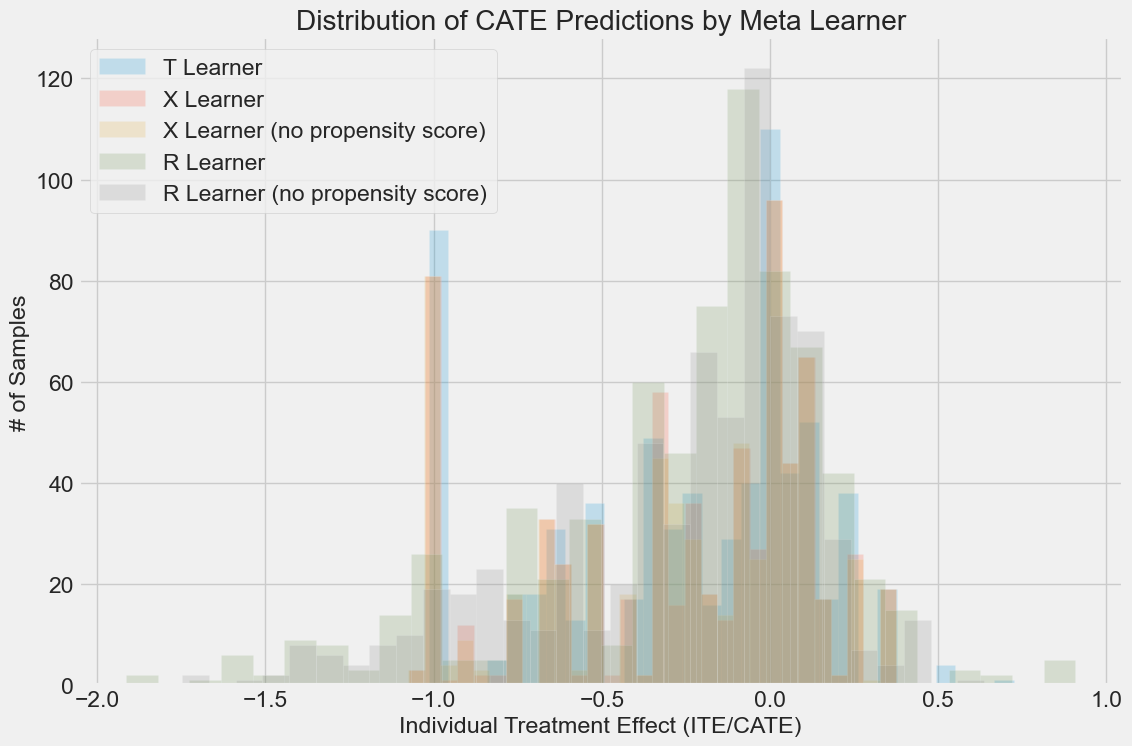

In [82]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(cate_x_no_p, alpha=alpha, bins=bins, label='X Learner (no propensity score)')
plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
plt.hist(cate_r_no_p, alpha=alpha, bins=bins, label='R Learner (no propensity score)')
# plt.vlines(cate_s[0], 0, plt.axes().get_ylim()[1], label='S Learner',
#            linestyles='dotted', colors='green', linewidth=2)
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

[Text(652.5, 472.5, 'X[0] <= 0.5\ngini = 0.412\nsamples = 714\nvalue = [350.144, 143.149]'),
 Text(326.25, 283.5, 'X[1] <= 17.5\ngini = 0.467\nsamples = 453\nvalue = [167.7, 98.844]'),
 Text(163.125, 94.5, 'gini = 0.262\nsamples = 58\nvalue = [37.002, 6.806]'),
 Text(489.375, 94.5, 'gini = 0.485\nsamples = 395\nvalue = [130.698, 92.038]'),
 Text(978.75, 283.5, 'X[1] <= 2.5\ngini = 0.314\nsamples = 261\nvalue = [182.444, 44.306]'),
 Text(815.625, 94.5, 'gini = 0.436\nsamples = 10\nvalue = [2.963, 6.266]'),
 Text(1141.875, 94.5, 'gini = 0.289\nsamples = 251\nvalue = [179.481, 38.039]')]

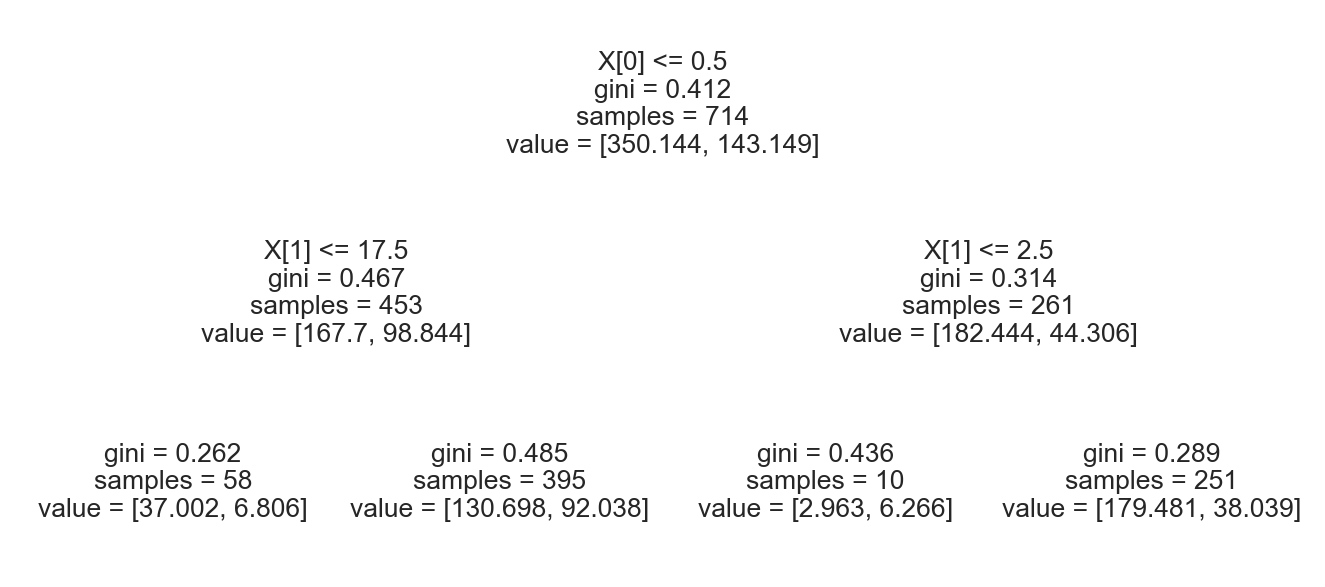

In [16]:
# 政策学习：X协变量，W混杂因子，e倾向得分，y因变量

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import cross_val_predict, KFold
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from causalml.optimize import PolicyLearner
from sklearn.tree import plot_tree
from lightgbm import LGBMRegressor
from causalml.inference.meta import BaseXRegressor

policy_learner = PolicyLearner(policy_learner=DecisionTreeClassifier(max_depth=2), calibration=True)
policy_learner.fit(X,treatment, y)
plt.figure(figsize=(15,7))
plot_tree(policy_learner.model_pi)

In [18]:
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.model_selection import train_test_split

In [27]:
# Look at the conversion rate and sample size in each group
df.pivot_table(values='convert',
               index='treatment',
               aggfunc=[np.mean, np.size],
               margins=True)

,mean,size
,convert,convert
treatment,,
0,0.571031,359
1,0.239437,355
All,0.406162,714


In [81]:

df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)
df_train['convert'] = df_train['convert'].astype('object')
df_train['treatment'] = df_train['treatment'].astype('string')
df_train.dtypes

convert       object
treatment     string
gender         int64
age          float64
score        float64
dtype: object

In [82]:
# Split data to training and testing samples for model validation (next section)
#df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

# Train uplift tree
uplift_model = UpliftTreeClassifier(max_depth = 4, min_samples_leaf = 200, min_samples_treatment = 50, n_reg = 100, evaluationFunction='KL', control_name='control')

uplift_model.fit(df_train[x_names].values,
                 treatment=df_train['treatment'].values,
                 y=df_train['convert'].values)

In [69]:
# Print uplift tree as a string
result = uplift_tree_string(uplift_model.fitted_uplift_tree, x_names)

[0.0, 0.5714285714285714, 0.25773195876288657]


cannot convert float NaN to integer


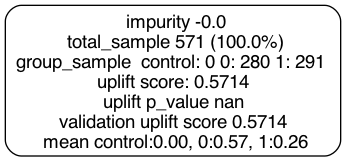

In [75]:
# Plot uplift tree
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree,x_names)
Image(graph.create_png())

cannot convert float NaN to integer


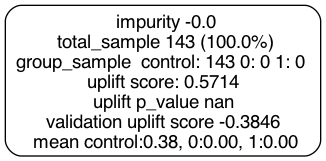

In [76]:
### Fill the trained tree with testing data set 
# The uplift score based on testing dataset is shown as validation uplift score in the tree nodes
df_test['convert'] = df_test['convert'].astype('object')
uplift_model.fill(X=df_test[x_names].values, treatment=df_test['treatment'].values, y=df_test['convert'].values)

# Plot uplift tree
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree,x_names)
Image(graph.create_png())

In [83]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)
df_train['convert'] = df_train['convert'].astype('object')
df_test['convert'] = df_test['convert'].astype('object')
df_train['treatment'] = df_train['treatment'].astype('string')
df_test['treatment'] = df_test['treatment'].astype('string')

df_train.dtypes

convert       object
treatment     string
gender         int64
age          float64
score        float64
dtype: object

In [84]:
# Train uplift tree
uplift_model = UpliftRandomForestClassifier(n_estimators=5, max_depth = 5, min_samples_leaf = 200, min_samples_treatment = 50, n_reg = 100, evaluationFunction='KL', control_name='control')

uplift_model.fit(df_train[x_names].values,
                 treatment=df_train['treatment'].values,
                 y=df_train['convert'].values)

In [85]:
# Specify a tree in the random forest (the index can be any integer from 0 to n_estimators-1)
uplift_tree = uplift_model.uplift_forest[0]
# Print uplift tree as a string
result = uplift_tree_string(uplift_tree.fitted_uplift_tree, x_names)

[0.0, 0.6462585034013606, 0.27075812274368233]


cannot convert float NaN to integer


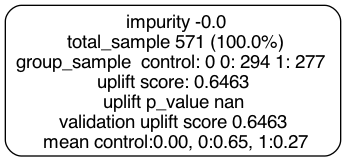

In [86]:
# Plot uplift tree
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree,x_names)
Image(graph.create_png())

In [88]:
df.head()

,convert,treatment,gender,age,score
0,0,1,0,22.0,0.65
1,1,0,1,38.0,0.28
2,1,1,1,26.0,0.41
3,1,0,1,35.0,0.31
4,0,1,0,35.0,0.50


In [89]:
## 结合shap来看特征重要性
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.dataset.regression import synthetic_data
from sklearn.linear_model import LinearRegression

import shap
import matplotlib.pyplot as plt

import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import os
import warnings
warnings.filterwarnings('ignore')

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # for lightgbm to work

%reload_ext autoreload
%autoreload 2
%matplotlib inline

plt.style.use('fivethirtyeight')


#n_features = 25
#n_samples = 10000
#y, X, w, tau, b, e = synthetic_data(mode=1, n=n_samples, p=n_features, sigma=0.5)

y = df['convert'].values
X = df[x_names].values
w = df['treatment'].values
e = df['score'].values

w_multi = np.array(['treatment' if x==1 else 'control' for x in w])
e_multi = {'treatment': e}

feature_names = x_names

model_tau = LGBMRegressor(importance_type='gain')  # specify model for model_tau

{'treatment': gender    1.407940
 age       0.958762
 dtype: float64}

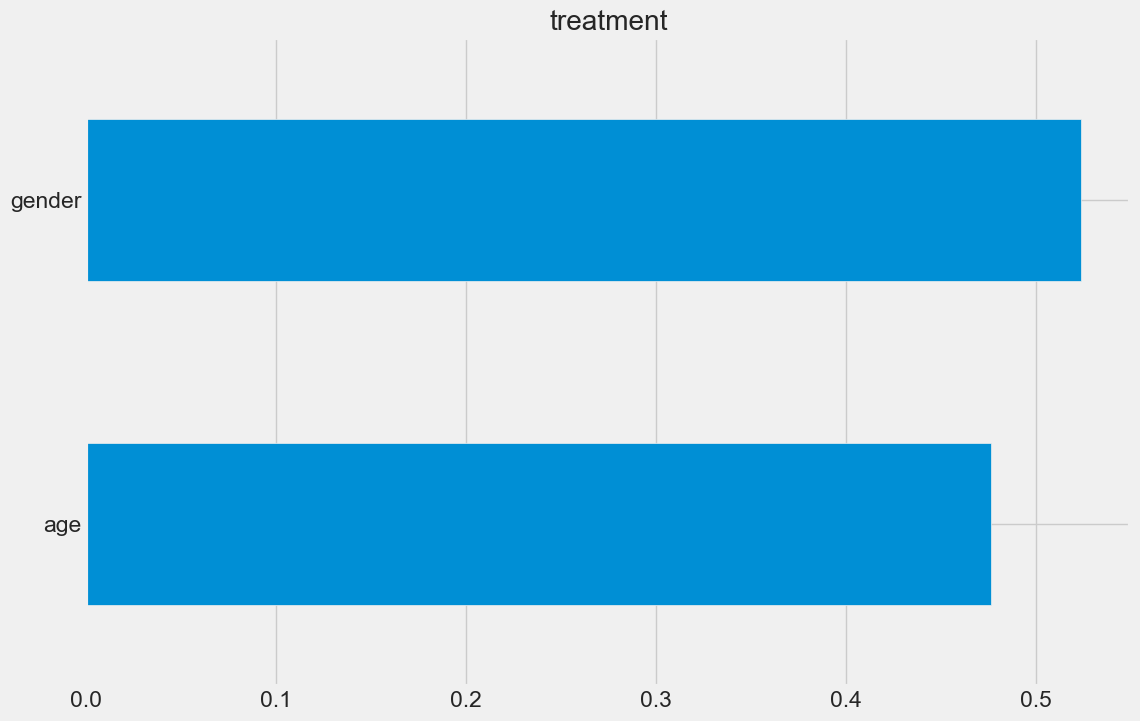

In [90]:
base_algo = LGBMRegressor()
# base_algo = XGBRegressor()
# base_algo = RandomForestRegressor()
# base_algo = LinearRegression()

slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

slearner_tau = slearner.fit_predict(X, w_multi, y)
# 模型的重要性方法一：AUTO
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

# 重要性方法二：permutation方法
slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

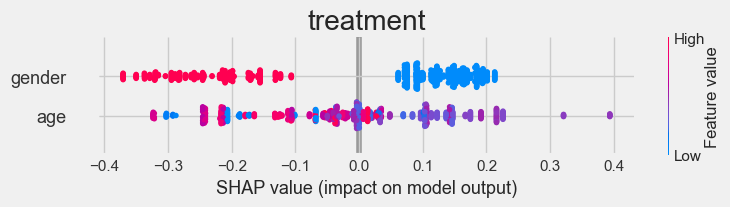

In [91]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)
shap_slearner
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau, features=feature_names)